In [1]:
from gym_compete_rllib.gym_compete_to_rllib import create_env, MultiAgentToSingleAgent, model_to_callable
from gym_compete_rllib.load_gym_compete_policy import get_policy_value_nets
from gym_compete_rllib.test_single_agent_env import episode
import gym
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import ray
from time import time
import pandas as pd

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
ray.shutdown()
info = ray.init(ignore_reinit_error=True, log_to_driver=False)
num_workers = 10
env_name = 'multicomp/YouShallNotPassHumans-v0'

2020-08-19 02:19:05,313	INFO resource_spec.py:204 -- Starting Ray with 3.86 GiB memory available for workers and up to 1.95 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-08-19 02:19:05,543	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-08-19 02:19:05,690	INFO services.py:1163 -- View the Ray dashboard at localhost:8267


In [5]:
env = create_env(config=dict(with_video=False, env_name=env_name))
policy_model_1 = model_to_callable(get_policy_value_nets(env_name, 1)['policy'])
env = MultiAgentToSingleAgent(env_config=dict(env=env, policies={'player_2': policy_model_1}))

Creating agent humanoid_blocker
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents
Creating agent humanoid_blocker
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents


In [24]:
@ray.remote
class Evaluator(object):
    """Evaluates a policy in the 1-agent env."""
    def __init__(self, env_name):
        env = create_env(config=dict(with_video=False, env_name=env_name))
        policy_model_1 = model_to_callable(get_policy_value_nets(env_name, 1)['policy'])
        self.env = MultiAgentToSingleAgent(env_config=dict(env=env, policies={'player_2': policy_model_1}))
    def episode(self, policy):
        return episode(self.env, policy)
    
def rewards(pool, ps):
    """Rewards for an array of policies."""
    return [v for v in pool.map(lambda a, v: a.episode.remote(v), ps)]

def compute_rewards(pool, p, total_episodes=100):
    """Compute rewards using a pool."""
    return [v for v in pool.map_unordered(lambda a, v: a.episode.remote(v), [p] * total_episodes)]

In [25]:
actors = [Evaluator.remote(env_name=env_name) for _ in range(num_workers)]
pool = ray.util.ActorPool(actors)

# Computing performance

In [49]:
random_policy = lambda _: np.random.randn(17)
policy_model_0 = model_to_callable(get_policy_value_nets(env_name, 0)['policy'])

Creating agent humanoid_blocker
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents


In [9]:
p = ray.put(random_policy)
total_episodes = 500

t = time()
R = compute_rewards(pool, p, total_episodes=total_episodes)
t = time() - t
print("Throughput:", total_episodes / t, "episodes/sec")

Throughput: 6.750376882405489 episodes/sec


/home/sergei/miniconda3/envs/chai3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sergei/miniconda3/envs/chai3.8/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


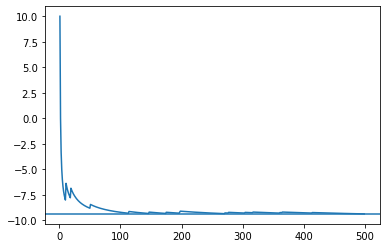

In [10]:
plt.plot([np.mean(R[:i]) for i in range(len(R))])
plt.axhline(np.mean(R))

In [11]:
total_episodes = 50

t = time()
R = [episode(env, policy_model_0) for _ in range(total_episodes)]
t = time() - t
print("Throughput:", total_episodes / t, "episodes/sec")

Throughput: 0.45114286124492026 episodes/sec


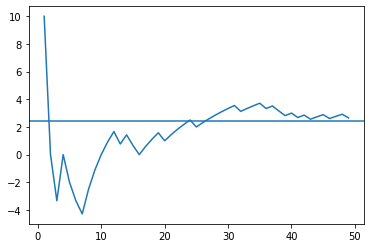

In [12]:
plt.plot([np.mean(R[:i]) for i in range(len(R))])
plt.axhline(np.mean(R))

# Analysis

In [2]:
import pickle

In [52]:
stats, p = pickle.load(open('evolve_result.pkl', 'rb'))

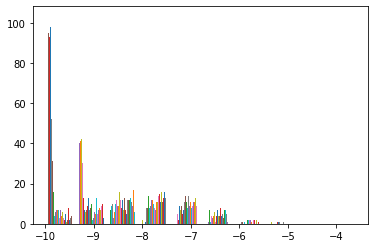

In [53]:
plt.hist(stats.get_fitness_stat(lambda x: x))
plt.show()

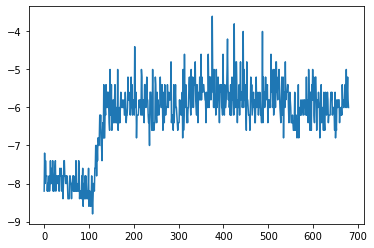

In [54]:
plt.plot(stats.get_fitness_stat(np.max))

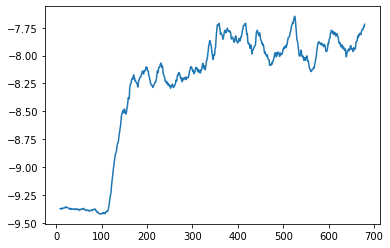

In [55]:
plt.plot(pd.Series(stats.get_fitness_mean()).rolling(10).mean())

In [56]:
700 * 50 * 20 * 150

105000000

# Using python-neat

In [11]:
import neat

In [9]:
fc_config_filename = 'fc.config'
num_workers = 10
eval_episodes = 20
population_size = 20

actors = [Evaluator.remote(env_name=env_name) for _ in range(num_workers)]
pool = ray.util.ActorPool(actors)

In [12]:
config_initial = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                             neat.DefaultSpeciesSet, neat.DefaultStagnation, fc_config_filename)

config_initial.genome_config.num_inputs = env.observation_space.shape[0]
config_initial.genome_config.num_outputs = env.action_space.shape[0]
config_initial.pop_size = population_size

In [13]:
game_fc_config_filename = 'fc-1.config'

config_initial.save(game_fc_config_filename)

config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation, game_fc_config_filename)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

In [14]:
# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
p.add_reporter(neat.Checkpointer(5))

In [44]:
def evaluate_genome(genome, config):
    network = neat.nn.FeedForwardNetwork.create(genome, config)
    net_policy = lambda obs, network=network: network.activate(obs)
    p = ray.put(net_policy)
    pool = ray.util.ActorPool(actors)
    R = compute_rewards(pool, p, total_episodes=50)
    fitness = np.mean(R)
    return fitness

def evaluate_genomes(genomes, config):
    nets = []
    for gid, g in genomes:
        net = neat.nn.FeedForwardNetwork.create(g, config)
        nets.append(lambda x, net=net: net.activate(x))
    policies = [ray.put(net) for net in nets]
    policies = [net for net in policies for _ in range(eval_episodes)]
    rs = rewards(pool, policies)
    rs = np.array(rs).reshape((len(genomes), eval_episodes))
    rs = np.mean(rs, axis=1)
    for (gid, g), r in zip(genomes, rs):
        g.fitness = r
    return rs

In [47]:
winner = p.run(evaluate_genomes, 33)


 ****** Running generation 0 ****** 

Population's average fitness: -9.66667 stdev: 0.82999
Best fitness: -6.00000 - size: (18, 415) - species 49 - id 49
Average adjusted fitness: 0.083
Mean genetic distance 2.372, standard deviation 0.477
Population of 180 members in 60 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0     3    -10.0    0.000     0
     2    0     3    -10.0    0.000     0
     3    0     3    -10.0    0.000     0
     4    0     3    -10.0    0.000     0
     5    0     3    -10.0    0.000     0
     6    0     3     -8.0    0.500     0
     7    0     3    -10.0    0.000     0
     8    0     3    -10.0    0.000     0
     9    0     3    -10.0    0.000     0
    10    0     3    -10.0    0.000     0
    11    0     3    -10.0    0.000     0
    12    0     3    -10.0    0.000     0
    13    0     3    -10.0    0.000     0
    14    0     3    -10.0    0.000     0
    15    0     3    -10.0    0.000     0
    

KeyboardInterrupt: 